In [76]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb 

from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score



import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import ResNet101

from tensorflow.keras import layers, Model


In [77]:
def model_def(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(50, input_shape=(input_shape,), activation='relu'),  # Layer input dengan 50 neuron
        tf.keras.layers.Dense(50, activation='relu'),  
        tf.keras.layers.Dense(4, activation='softmax') 
    ])
    return model

def model_dropout1(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(50, input_shape=(input_shape,), activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(50, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(4, activation='softmax')
    ])
    return model

def residual_block(input_tensor, filters):
    x = tf.keras.layers.Dense(filters, activation='relu')(input_tensor)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Dense(filters, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    # Shortcut connection
    shortcut = tf.keras.layers.Dense(filters)(input_tensor)
    shortcut = tf.keras.layers.BatchNormalization()(shortcut)
    # Tambahkan shortcut ke output
    x = tf.keras.layers.Add()([x, shortcut])
    x = tf.keras.layers.Activation('relu')(x)
    return x

def resnet_tabular(input_shape):

    # Membuat model ResNet untuk data Iris
    input_shape = input_shape

    inputs = tf.keras.layers.Input(shape=(input_shape,))
    x = tf.keras.layers.Reshape((input_shape, 1))(inputs)  # Menambahkan dimensi untuk keperluan Conv1D

    x = residual_block(x, 64)
    x = tf.keras.layers.Flatten()(x)
    outputs = tf.keras.layers.Dense(4, activation='softmax')(x)  # Output layer dengan 3 kelas (Iris memiliki 3 kelas)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model


def set_callbacks(model_name):
    callbacks = [
    # Early stopping untuk menghentikan pelatihan jika tidak ada peningkatan dalam validasi setelah beberapa epoch
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    
    # ModelCheckpoint untuk menyimpan model dengan akurasi validasi terbaik
    ModelCheckpoint(f'{model_name}.h5', monitor='val_accuracy', save_best_only=True)
    ]
    return callbacks




In [78]:
lda = LinearDiscriminantAnalysis()

In [79]:
df = pd.read_csv(f'./dataset/dogcat-encode/encoded-dogcat-img-32.csv')
df = df.iloc[:,1:]
df = df.loc[:, (df != 0).any(axis=0)]

X = df.iloc[:,:-1]
y = df.iloc[:,-1:]

X_lda = lda.fit_transform(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_lda, y, test_size=0.2, random_state=42)

c:\ProgramData\anaconda3\envs\mdl\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [90]:
model_default = model_def(X_train.shape[1])
model_dropout = model_dropout1(X_train.shape[1])
model_resnet = resnet_tabular(X_train.shape[1])

models = [model_default, model_dropout, model_resnet]
model_names = ['default', 'dropout1', 'resnet']
# print(models[0])
X_train.shape[1]

3

In [81]:
accuracies = []
histories = []


for i, model in enumerate(models):
    # Compile model
    models[i].compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Latih model
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=set_callbacks(model_names[i]))
    histories.append(history)

    last_accuracy = history.history['val_accuracy'][-1]  # Mengambil akurasi validasi terakhir
    accuracies.append(last_accuracy)

Epoch 1/50
21/21 [==============================] - 1s 17ms/step - loss: 0.7329 - accuracy: 0.8279 - val_loss: 0.3230 - val_accuracy: 1.0000
Epoch 2/50
21/21 [==============================] - 0s 4ms/step - loss: 0.1939 - accuracy: 1.0000 - val_loss: 0.1049 - val_accuracy: 1.0000
Epoch 3/50
21/21 [==============================] - 0s 4ms/step - loss: 0.0681 - accuracy: 1.0000 - val_loss: 0.0503 - val_accuracy: 1.0000
Epoch 4/50
21/21 [==============================] - 0s 4ms/step - loss: 0.0330 - accuracy: 1.0000 - val_loss: 0.0312 - val_accuracy: 1.0000
Epoch 5/50
21/21 [==============================] - 0s 4ms/step - loss: 0.0199 - accuracy: 1.0000 - val_loss: 0.0218 - val_accuracy: 1.0000
Epoch 6/50
21/21 [==============================] - 0s 5ms/step - loss: 0.0136 - accuracy: 1.0000 - val_loss: 0.0165 - val_accuracy: 1.0000
Epoch 7/50
21/21 [==============================] - 0s 4ms/step - loss: 0.0099 - accuracy: 1.0000 - val_loss: 0.0134 - val_accuracy: 1.0000
Epoch 8/50
21/21 [=

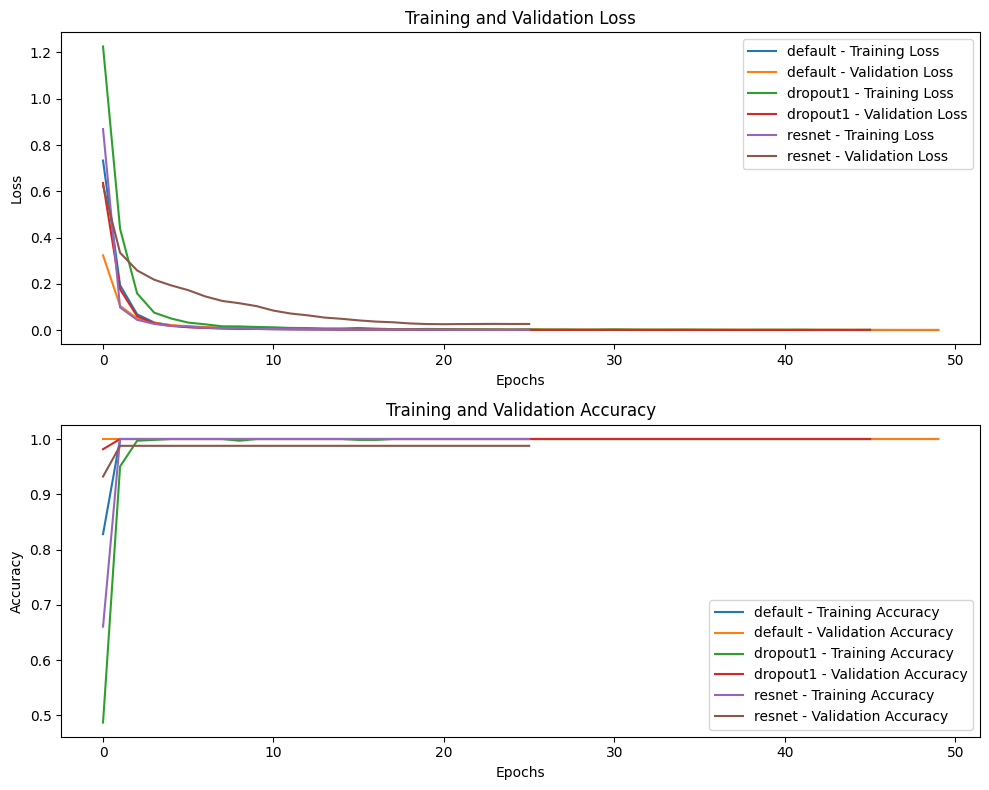

In [82]:
# Plot loss
plt.figure(figsize=(10, 8))
for i, history in enumerate(histories):
    plt.subplot(2, 1, 1)  # Dua baris, satu kolom, plot pertama
    plt.plot(history.history['loss'], label=f'{model_names[i]} - Training Loss')
    plt.plot(history.history['val_loss'], label=f'{model_names[i]} - Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

# Plot akurasi
for i, history in enumerate(histories):
    plt.subplot(2, 1, 2)  # Dua baris, satu kolom, plot kedua
    plt.plot(history.history['accuracy'], label=f'{model_names[i]} - Training Accuracy')
    plt.plot(history.history['val_accuracy'], label=f'{model_names[i]} - Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

plt.tight_layout()
plt.show()

In [83]:
res = pd.DataFrame({
    'dataset_source': model_names,
    'accuracy' : accuracies
})

res.head()

,dataset_source,accuracy
0,default,1.000000
1,dropout1,1.000000
2,resnet,0.987654


In [94]:
pred = models[2].predict(X_lda)
pred = np.argmax(models[2].predict(X_lda), axis=1)
pred

26/26 [==============================] - 0s 2ms/step


array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [91]:
def create_xgboost_model():
    return xgb.XGBClassifier()

def create_mlp_classifier():
    return MLPClassifier(random_state=42)

def create_random_forest_classifier():
    return RandomForestClassifier(random_state=42)

def train_evaluate_model(model, X_train, y_train, X_test, y_test):
    # Fit model
    model.fit(X_train, y_train)
    
    # Prediksi menggunakan model
    predictions = model.predict(X_test)
    print(predictions)
    predictions = np.argmax(predictions, axis=1)

    y_test = y_test.to_numpy()
    # print(predictions)
    # print(y_test)
    # Evaluasi model
    accuracy = accuracy_score(y_test, predictions)
    
    return accuracy

In [85]:
xgboost_model = create_xgboost_model()
mlp_model = create_mlp_classifier()
random_forest_model = create_random_forest_classifier()

models2 = [xgboost_model, mlp_model, random_forest_model]
model2_names = ['xgboost', 'mlp', 'random_forest_model']

In [86]:
y_test

,0.1
697,3
296,1
227,1
336,1
537,2
...,...
668,3
673,3
753,3
751,3


In [87]:
accuracies2 = []

for i, model in enumerate(models):
    accuracy = train_evaluate_model(models[i], X_train, y_train, X_test, y_test)
    accuracies2.append(accuracy)

21/21 [==============================] - 0s 2ms/step - loss: 2.3922e-04 - accuracy: 1.0000


6/6 [==============================] - 0s 2ms/step


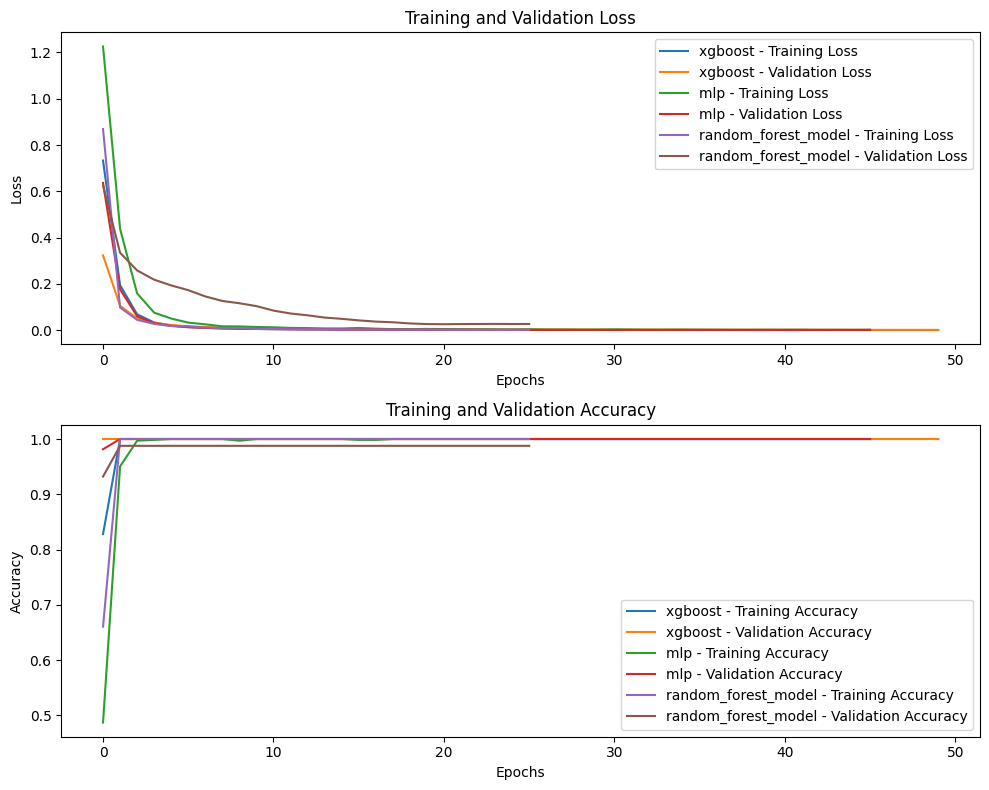

In [88]:
# Plot loss
plt.figure(figsize=(10, 8))
for i, history in enumerate(histories):
    plt.subplot(2, 1, 1)  # Dua baris, satu kolom, plot pertama
    plt.plot(history.history['loss'], label=f'{model2_names[i]} - Training Loss')
    plt.plot(history.history['val_loss'], label=f'{model2_names[i]} - Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

# Plot akurasi
for i, history in enumerate(histories):
    plt.subplot(2, 1, 2)  # Dua baris, satu kolom, plot kedua
    plt.plot(history.history['accuracy'], label=f'{model2_names[i]} - Training Accuracy')
    plt.plot(history.history['val_accuracy'], label=f'{model2_names[i]} - Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

plt.tight_layout()
plt.show()

In [89]:
res2 = pd.DataFrame({
    'dataset_source': model_names,
    'accuracy' : accuracies2
})

res2.head()

,dataset_source,accuracy
0,default,1.000000
1,dropout1,1.000000
2,resnet,0.987654
